### Introduction
Author: Jake Goh

Date: 9th February 2026

Description:
This notebook performs Exploratory Data Analysis on the modelled PV generation output from Atlite. We are looking to see if it creates, prepares and set up the data for pv calculation correctly using the newly added ERA5 Land dataset. 


In [1]:
import atlite
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
from rasterio.features import rasterize
import numpy as np
import matplotlib.colors as colors

## Topic 1: 
### How does the PV output looks like for ERA5 Land?
1. Let's get the PV output from atlite
2. Compare to see if we have better improvements with ERA5 dataset

### ERA 5 Land PV potential.

This is the generic cutout without specifying the grid size. Notice how the resolution is also the same as ERA5 (no improvements) since the default resolution is 0.25 x 0.25 degrees. 


In [ ]:
###Step 1. Create cutout

era5_land_cutout = atlite.Cutout(
    path = "./data/malaysia-2022.nc",
    module = "era5_land",
    bounds = (99, 0, 120, 8),
    time = "2022",
)


###Step 2. Prepare cutout
era5_land_cutout.prepare()

###Step 3. Calculate pv
# 1. Khatib et al. (2012)
# Optimal fixed tilt angle: 5°–15°. South-facing orientation slightly preferred

#This is the total potential PV generation for the entire area with given panel and orientation
era5_land_pv = era5_land_cutout.pv(
    panel="CSi",
    orientation={"slope": 10.0, "azimuth": 180.0}
)

#Can also do this to get the optimal tilt angle based on latitude
#pv_opt = cutout.pv(panel="CSi", orientation="latitude_optimal")

print(era5_land_pv)


C:\Users\gohng\OneDrive\Documents\Python projects\Atlite\atlite\atlite\cutout.py:157: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(
c:\Users\gohng\.conda\envs\atlite_clean\lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


<xarray.DataArray 'specific generation' (y: 33, x: 85)> Size: 22kB
array([[1358.44939817, 1359.28595508, 1325.57585382, ..., 1503.63545174,
        1487.65165197, 1491.85653422],
       [1360.94295938, 1339.16287666, 1296.89762474, ..., 1508.68366423,
        1480.38767427, 1445.48553529],
       [1347.28178725, 1326.7358042 , 1293.68587645, ..., 1505.03374729,
        1477.77051059, 1441.21357101],
       ...,
       [1482.59575815, 1429.25325086, 1363.28643953, ..., 1427.55805884,
        1431.32615664, 1435.95482051],
       [1421.23948457, 1375.70649319, 1336.35669788, ..., 1431.63802047,
        1433.99179153, 1437.47738333],
       [1360.18544973, 1331.3374855 , 1315.25417983, ..., 1435.72740539,
        1437.56398385, 1439.49032714]], shape=(33, 85))
Coordinates:
  * x        (x) float64 680B 99.0 99.25 99.5 99.75 ... 119.2 119.5 119.8 120.0
  * y        (y) float64 264B 0.0 0.25 0.5 0.75 1.0 ... 7.0 7.25 7.5 7.75 8.0
    lon      (x) float64 680B 99.0 99.25 99.5 99.75 ... 119.2

c:\Users\gohng\.conda\envs\atlite_clean\lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\gohng\.conda\envs\atlite_clean\lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\gohng\.conda\envs\atlite_clean\lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\gohng\.conda\envs\atlite_clean\lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\gohng\.conda\envs\atlite_clean\lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\gohng\.conda\envs\atlite_clean\lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec

Text(0.5, 1.0, 'PV Modelled Energy Production in Malaysia in 2022')

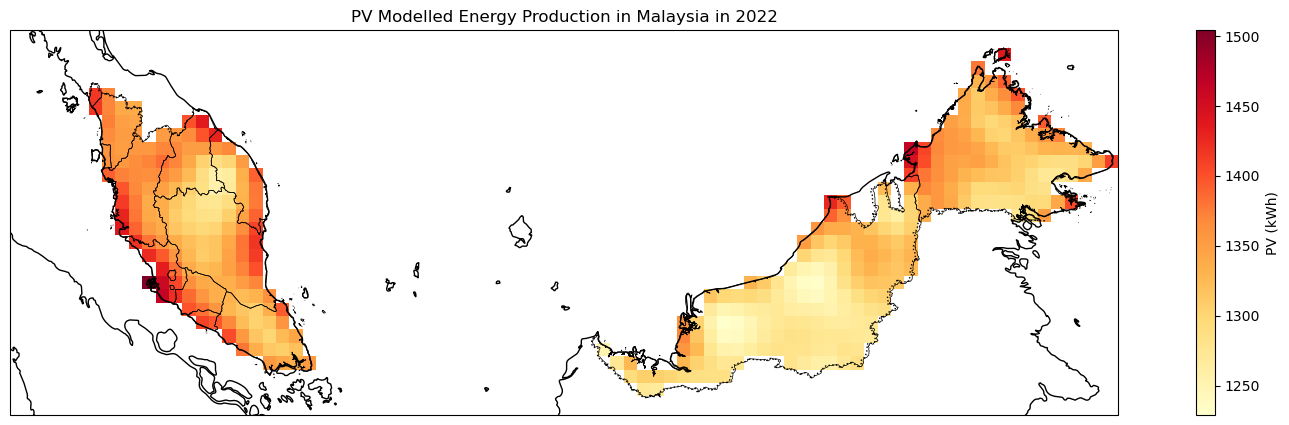

In [ ]:
#Visualizing the data

malaysia = gpd.read_file('data/gadm41_MYS_shp/gadm41_MYS_1.shp')
malaysia = malaysia.to_crs(era5_land_cutout.crs)

# Create map figure
fig, axes = plt.subplots(1, 1, figsize=(20, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})



# Assigning CRS to the data
pv_plot_data = era5_land_pv.rio.write_crs(era5_land_cutout.crs)

#Clipping based on the mask
pv_plot_data = pv_plot_data.rio.clip(malaysia.geometry, malaysia.crs)


pv_plot_data.plot(
                x="x", y="y",
                ax=axes, transform=ccrs.PlateCarree(),
                cbar_kwargs={"label": "PV (kWh)"},
                cmap='YlOrRd'
                )

malaysia.boundary.plot(
    ax=axes,
    transform=ccrs.PlateCarree(),
    edgecolor="black",
    linewidth=0.5,
    zorder=5
)   


axes.coastlines(resolution="10m")
axes.add_feature(cfeature.BORDERS, linestyle=":")
axes.set_title("PV Modelled Energy Production in Malaysia in 2022")

In [ ]:
#The above shows if we have 1 kW of installed capacity in each grid cell, how much energy (in kWh) can be generated in a year. So this is a potential map, 
#and it does not assume how much solar is actually built. 

#kWp = kilowatt-peak. Which is the maximum output of a solar panel under standard test conditions. 
#Standard test conditions (STC) are defined as a cell temperature of 25°C, an irradiance of 1000 W/m², and an air mass of 1.5.
#Which is not the same as real life conditions especially in a tropical country like Malaysia since temperature is usually higher than 25°C. 
#This is adjusted in the model 

### ERA 5 Land PV potential with better resolution.

Previously, the resolution is defauted to 0.25. The one below is a better cutout since the resolution has been improved to 0.1. This is the main purpose of the project which is to give better resolution to the data. 

In [2]:
years = ["2020", "2021", "2022", "2023", "2024", "2025"]

era5_land_pv_list = []

for year in years:
    cutout = atlite.Cutout(
        path=f"./data/malaysia-{year}-0.1resolution.nc",
        module="era5_land",
        bounds=(99, 0, 120, 8),
        time=year,
        dx = 0.1,
        dy = 0.1
    )

    cutout.prepare()

    pv = cutout.pv(
        panel="CSi",
        orientation="latitude_optimal",
    )

    era5_land_pv_list.append(pv)

# Concatenate along time
era5_land_pv_all = xr.concat(era5_land_pv_list, dim="time")
time_index = pd.to_datetime([f"{y}-01-01" for y in years])

# Ensure proper time coordinate (datetime, not string)
era5_land_pv_all = era5_land_pv_all.assign_coords(
    time=time_index
)

era5_land_pv_all.name = "pv_specific_generation"
era5_land_pv_all.attrs["units"] = "kWh/kWp"



C:\Users\gohng\OneDrive\Documents\Python projects\Atlite\atlite\atlite\cutout.py:157: UserWarning: Arguments module, bounds, time, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\gohng\.conda\envs\atlite_clean\lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
C:\Users\gohng\OneDrive\Documents\Python projects\Atlite\atlite\atlite\cutout.py:157: UserWarning: Arguments module, bounds, time, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\gohng\.conda\envs\atlite_clean\lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
C:\Users\gohng\OneDrive\Documents\Python projects\Atlite\atlite\atlite\cutout.py:157: UserWarning: Arguments module, bounds, time, dx, dy are ignored, since cutout is already built.
  warn(
c:\Users\gohng\.conda\envs\atlite_clean\lib\site-packages\dask\_task_spec.py:759: RuntimeWarning

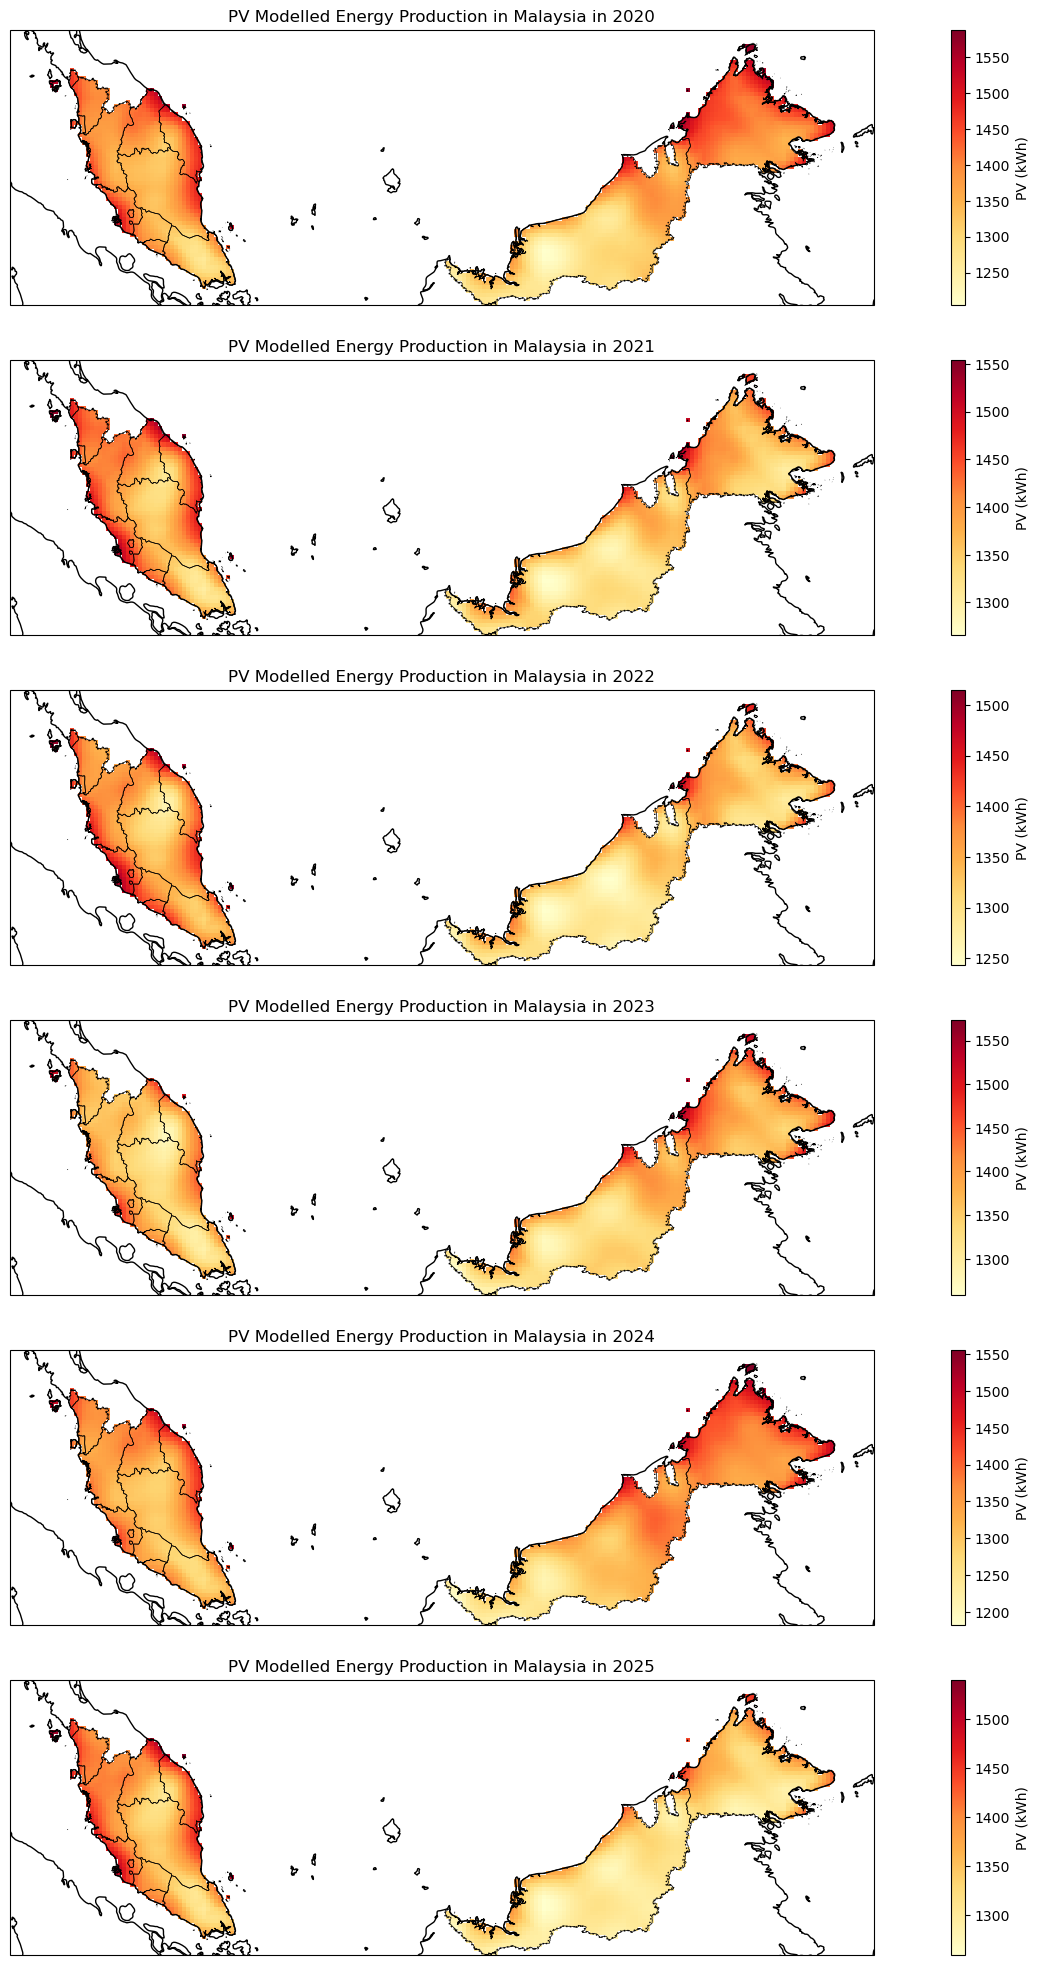

In [ ]:
# Visualize the pv for each year
malaysia = gpd.read_file('data/gadm41_MYS_shp/gadm41_MYS_1.shp')
malaysia = malaysia.to_crs(cutout.crs)

# Create map figure
fig, axes = plt.subplots(6, 1, figsize=(20, 25),
                         subplot_kw={'projection': ccrs.PlateCarree()})



for idx, ax in enumerate(axes):

    pv = era5_land_pv_all.sel(time=years[idx])
    
    # Assigning CRS to the data
    pv_plot_data = pv.rio.write_crs(cutout.crs)

    #Clipping based on the mask
    pv_plot_data = pv_plot_data.rio.clip(malaysia.geometry, malaysia.crs)


    pv_plot_data.plot(
                    x="x", y="y",
                    ax=ax, transform=ccrs.PlateCarree(),
                    cbar_kwargs={"label": "PV (kWh)"},
                    cmap='YlOrRd')
    
    malaysia.boundary.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    edgecolor="black",
    linewidth=0.5,
    zorder=5
    )   

    ax.coastlines(resolution="10m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.set_title(f"PV Modelled Energy Production in Malaysia in {years[idx]}")

### ERA 5 Land PV potential average across the years

In [4]:
#Get the average value across all years for each cell
era5_land_pv_mean = era5_land_pv_all.mean(dim='time')

print(era5_land_pv_mean)

<xarray.DataArray 'pv_specific_generation' (y: 81, x: 211)> Size: 137kB
array([[1410.00233168, 1411.56111485, 1412.96077695, ..., 1524.30591068,
        1523.95118367, 1523.34162342],
       [1408.6289122 , 1410.13706224, 1406.60761444, ..., 1515.58325145,
        1507.19565874, 1506.58485459],
       [1406.98987499, 1403.57222453, 1395.0965853 , ..., 1514.62781744,
        1498.17139723, 1489.48969265],
       ...,
       [1450.96622365, 1435.69174702, 1416.88443212, ..., 1479.21842947,
        1479.40317528, 1479.3044073 ],
       [1425.92183044, 1414.17234874, 1398.85150835, ..., 1479.30726458,
        1479.34012359, 1479.10076297],
       [1400.71502137, 1388.99471291, 1377.13416845, ..., 1479.09823614,
        1478.99440031, 1478.75120107]], shape=(81, 211))
Coordinates:
  * y        (y) float64 648B -0.0 0.1 0.2 0.3 0.4 0.5 ... 7.6 7.7 7.8 7.9 8.0
    lat      (y) float64 648B -0.0 0.1 0.2 0.3 0.4 0.5 ... 7.6 7.7 7.8 7.9 8.0
  * x        (x) float64 2kB 99.0 99.1 99.2 99.3 ... 11

Text(0.5, 1.0, 'Average Yearly PV Modelled Energy Production in Malaysia from 2022 to 2025')

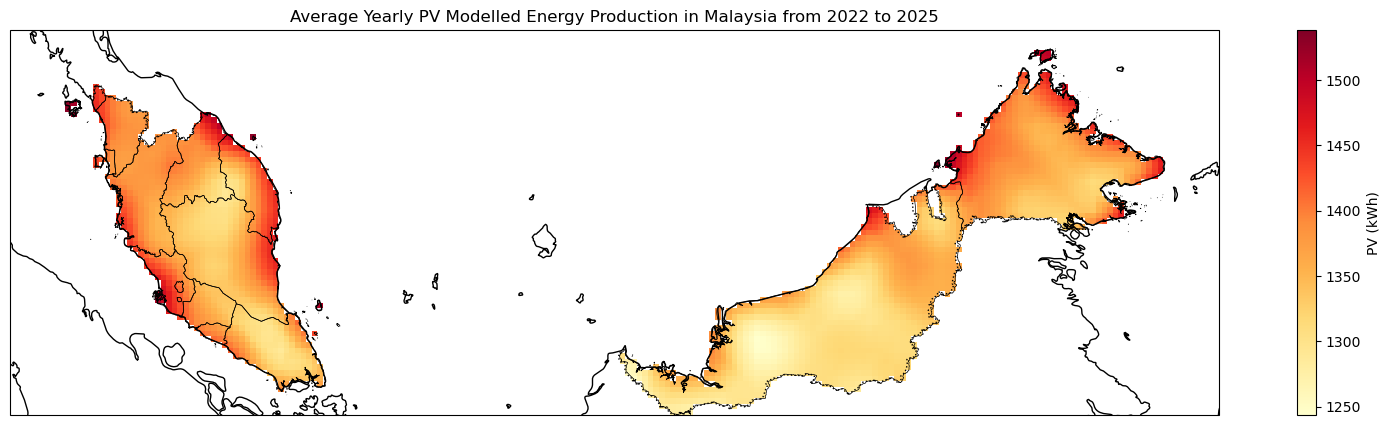

In [ ]:
malaysia = gpd.read_file('data/gadm41_MYS_shp/gadm41_MYS_1.shp')
malaysia = malaysia.to_crs(cutout.crs)

# Create map figure
fig, axes = plt.subplots(1, 1, figsize=(20, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})


# Assigning CRS to the data
pv_plot_data = era5_land_pv_mean.rio.write_crs(cutout.crs)

#Clipping based on the mask
pv_plot_data = pv_plot_data.rio.clip(malaysia.geometry, malaysia.crs)


pv_plot_data.plot(
                x="x", y="y",
                ax=axes, transform=ccrs.PlateCarree(),
                cbar_kwargs={"label": "PV (kWh)"},
                cmap='YlOrRd')


# Plot Malaysia admin-1 boundaries from GADM
malaysia.boundary.plot(
    ax=axes,
    transform=ccrs.PlateCarree(),
    edgecolor="black",
    linewidth=0.5,
    zorder=5
)

axes.coastlines(resolution="10m")
axes.add_feature(cfeature.BORDERS, linestyle=":")

axes.set_title("Average Yearly PV Modelled Energy Production in Malaysia from 2022 to 2025")

### Comparing with ERA5 data

In [6]:
#Step 1. Create cutout
era5_cutout = atlite.Cutout(
    path=f"./data/era-5-malaysia-2022.nc",
    module="era5",
    bounds=(99, 0, 120, 8),
    time= "2022",
)

#Step 2. Prepare cutout
era5_cutout.prepare(features=['influx', 'temperature'])

#Step 3. Calculate pv
era5_pv = era5_cutout.pv(
    panel="CSi",
    orientation="latitude_optimal",
)

print(era5_pv)

C:\Users\gohng\OneDrive\Documents\Python projects\Atlite\atlite\atlite\cutout.py:157: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(


<xarray.DataArray 'specific generation' (y: 33, x: 85)> Size: 22kB
array([[1378.27171333, 1379.38204048, 1344.69686563, ..., 1528.98224926,
        1511.47156113, 1515.32502649],
       [1380.20172338, 1357.68918992, 1314.34084461, ..., 1534.40449996,
        1504.15635578, 1466.721376  ],
       [1365.78972895, 1344.090433  , 1310.45515104, ..., 1530.80175791,
        1501.5473137 , 1462.23420639],
       ...,
       [1491.04527848, 1437.82148753, 1371.56231262, ..., 1442.51497955,
        1446.58071902, 1451.35278338],
       [1429.46623426, 1383.86832059, 1344.63471177, ..., 1446.5261761 ,
        1449.10879663, 1452.7040565 ],
       [1368.14110979, 1339.37004515, 1323.48639694, ..., 1450.35755323,
        1452.5220764 , 1454.48630895]], shape=(33, 85))
Coordinates:
  * y        (y) float64 264B 0.0 0.25 0.5 0.75 1.0 ... 7.0 7.25 7.5 7.75 8.0
    lat      (y) float64 264B 0.0 0.25 0.5 0.75 1.0 ... 7.0 7.25 7.5 7.75 8.0
  * x        (x) float64 680B 99.0 99.25 99.5 99.75 ... 119.2 1

Text(0.5, 1.0, 'ERA5 PV Modelled Energy Production in Malaysia in 2022')

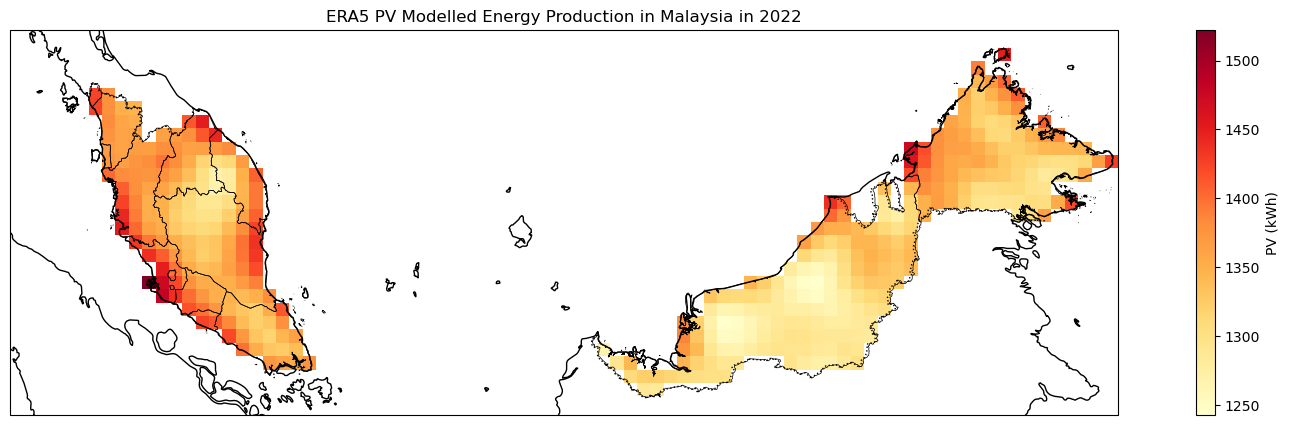

In [ ]:
malaysia = gpd.read_file('data/gadm41_MYS_shp/gadm41_MYS_1.shp')
malaysia = malaysia.to_crs(cutout.crs)

# Create map figure
fig, axes = plt.subplots(1, 1, figsize=(20, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})



# Assigning CRS to the data
pv_plot_data = era5_pv.rio.write_crs(era5_cutout.crs)

#Clipping based on the mask
pv_plot_data = pv_plot_data.rio.clip(malaysia.geometry, malaysia.crs)


pv_plot_data.plot(
                x="x", y="y",
                ax=axes, transform=ccrs.PlateCarree(),
                cbar_kwargs={"label": "PV (kWh)"},
                cmap='YlOrRd')

malaysia.boundary.plot(
    ax=axes,
    transform=ccrs.PlateCarree(),
    edgecolor="black",
    linewidth=0.5,
    zorder=5
)

axes.coastlines(resolution="10m")
axes.add_feature(cfeature.BORDERS, linestyle=":")
axes.set_title("ERA5 PV Modelled Energy Production in Malaysia in 2022")


Notice that the ERA5_Land have much better resolution at 0.1 x 0.1 degrees (9km) vs ERA5 at 0.25 x 0.25 degrees (31 km)

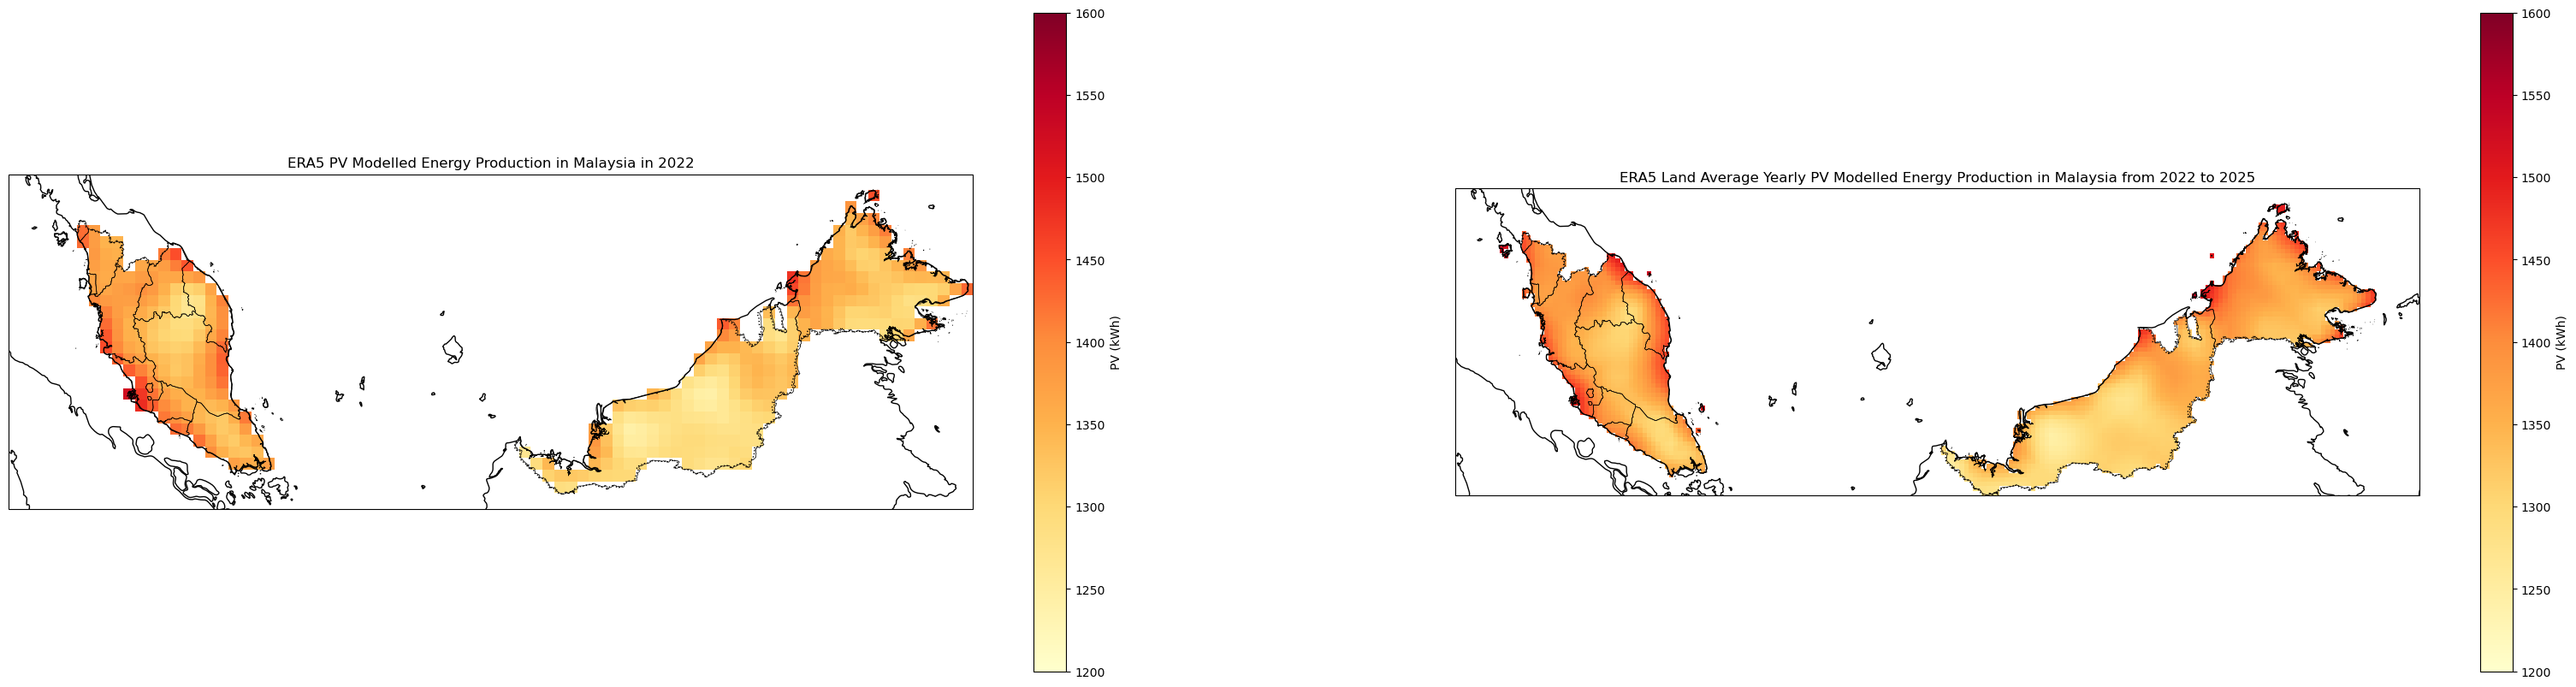

In [ ]:
#Putting both graphs side by side for comparison
malaysia = gpd.read_file('data/gadm41_MYS_shp/gadm41_MYS_1.shp')
malaysia = malaysia.to_crs(cutout.crs)

# Create map figure
fig, axes = plt.subplots(1, 2, figsize=(40, 10),
                         subplot_kw={'projection': ccrs.PlateCarree()})


for i in range(2):
    if i == 0:
        pv_data = era5_pv
        title = "ERA5 PV Modelled Energy Production in Malaysia in 2022"
    
    else:
        pv_data = era5_land_pv_mean
        title = "ERA5 Land Average Yearly PV Modelled Energy Production in Malaysia from 2022 to 2025"
    
    # Assigning CRS to the data
    pv_plot_data = pv_data.rio.write_crs(era5_cutout.crs)

    #Clipping based on the mask
    pv_plot_data = pv_plot_data.rio.clip(malaysia.geometry, malaysia.crs)


    pv_plot_data.plot(
                    x="x", y="y",
                    ax=axes[i], transform=ccrs.PlateCarree(),
                    vmin=1200, vmax=1600,
                    cbar_kwargs={"label": "PV (kWh)"},
                    cmap='YlOrRd')

    malaysia.boundary.plot(
        ax=axes[i],
        transform=ccrs.PlateCarree(),
        edgecolor="black",
        linewidth=0.5,
        zorder=5
    )

    axes[i].coastlines(resolution="10m")
    axes[i].add_feature(cfeature.BORDERS, linestyle=":")
    axes[i].set_title(title)




## Topic 2:
1. Get the data for all years, and let's see if we can make a conclusion.
2. Which state/area is the best for pv solar farms? (need to add that granularity)
3. Produce a bar chart on the avg


In [ ]:
# We need rasterize the state boundaries into the same grid to do state statistics


#Steps: 
# 1. The reference is the pv grid. So everything must match the pv grid
# 2. Load admin boundary shapefile for state polygons. Must also match CRS (GADM)
# 3. Rasterize each state polygon into the pv grid. Each cell will have either 1 (inside state) or 0 (outside state), or a fractional overlap. 


### Step 1. Create reference. 
pv_data = era5_land_pv_mean
pv_data = pv_data.rio.write_crs(cutout.crs)

### Step 2. Load admin boundary shapefile for state polygons.
malaysia_states = gpd.read_file('data/gadm41_MYS_shp/gadm41_MYS_1.shp')
malaysia_states = malaysia_states.to_crs(cutout.crs)

#Add state_id column into the dataframe
malaysia_states['state_id'] = malaysia_states.index + 1

#Fixing the naming
malaysia_states.loc[malaysia_states["NAME_1"] == 'Trengganu', "NAME_1"] = 'Terengganu'

#Create a lookup dictionary for state_id to state_name for later renaming
state_lookup = dict(zip(malaysia_states["state_id"], malaysia_states["NAME_1"]))

###Step 3. Rasterize states to pv grid
shapes = zip(malaysia_states.geometry, malaysia_states["state_id"])

state_raster = rasterize(
    shapes=shapes,
    out_shape=(pv_data.sizes["y"], pv_data.sizes["x"]),
    transform=pv_data.rio.transform(),
    default_value='',
    dtype="int16"
)

#Convert raster to xarray DataArray
state_da = xr.DataArray(
    state_raster,
    coords={"y": pv_data.y, "x": pv_data.x},
    dims=("y", "x"),
    name="state_id"
)

state_da = state_da.rio.write_crs(pv_data.rio.crs)

state_da

#Combine with pv_data to create a new DataArray with dimension 'state'
ds_era5_land = xr.Dataset({
    "pv": era5_land_pv_mean,
    "state_id": state_da
})

print(ds_era5_land)

<xarray.Dataset> Size: 176kB
Dimensions:      (y: 81, x: 211)
Coordinates:
  * y            (y) float64 648B -0.0 0.1 0.2 0.3 0.4 ... 7.6 7.7 7.8 7.9 8.0
    lat          (y) float64 648B -0.0 0.1 0.2 0.3 0.4 ... 7.6 7.7 7.8 7.9 8.0
  * x            (x) float64 2kB 99.0 99.1 99.2 99.3 ... 119.7 119.8 119.9 120.0
    lon          (x) float64 2kB 99.0 99.1 99.2 99.3 ... 119.7 119.8 119.9 120.0
    spatial_ref  int64 8B 0
Data variables:
    pv           (y, x) float64 137kB 1.41e+03 1.412e+03 ... 1.479e+03 1.479e+03
    state_id     (y, x) int16 34kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0


In [ ]:
#This is the lookup dictionary for state_id to state_name
print(state_lookup)

{1: 'Johor', 2: 'Kedah', 3: 'Kelantan', 4: 'Kuala Lumpur', 5: 'Labuan', 6: 'Melaka', 7: 'Negeri Sembilan', 8: 'Pahang', 9: 'Perak', 10: 'Perlis', 11: 'Pulau Pinang', 12: 'Putrajaya', 13: 'Sabah', 14: 'Sarawak', 15: 'Selangor', 16: 'Terengganu'}


Text(0.5, 1.0, 'ERA5 Land State Mask in Malaysia')

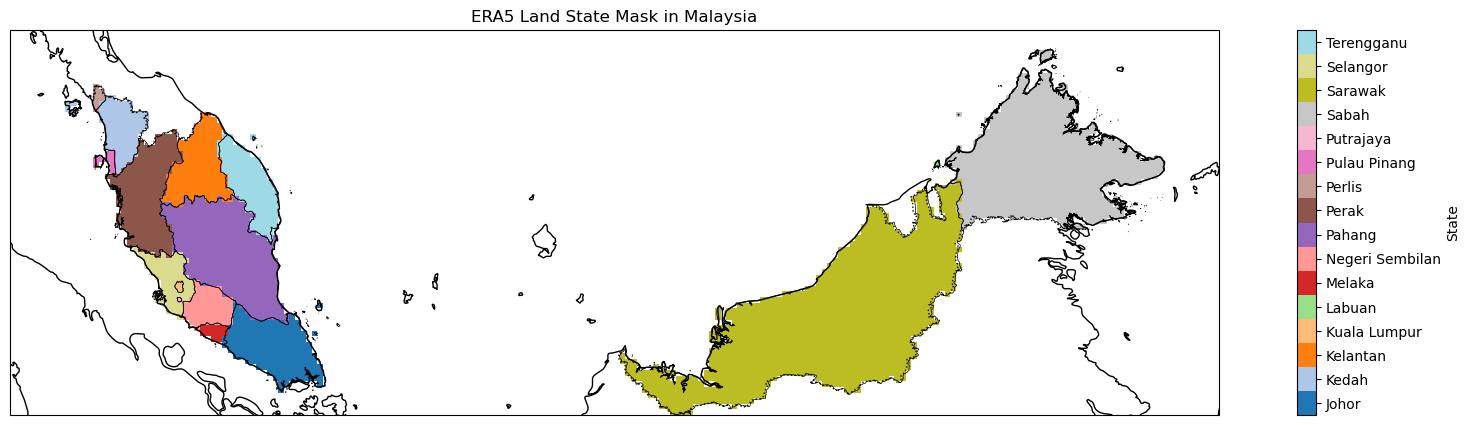

In [11]:
#Visualize the state raster
malaysia = gpd.read_file('gadm41_MYS_shp/gadm41_MYS_1.shp')
malaysia = malaysia.to_crs(cutout.crs)

# Create map figure
fig, axes = plt.subplots(1, 1, figsize=(20, 5),
                         subplot_kw={'projection': ccrs.PlateCarree()})


plot_data = ds_era5_land["state_id"].where(ds_era5_land["state_id"] != 0)

# Assigning CRS to the data
plot_data = plot_data.rio.write_crs(cutout.crs)

#Clipping based on the mask
plot_data = plot_data.rio.clip(malaysia.geometry, malaysia.crs)

# Boundaries: [-0.5, 0.5, 1.5, 2.5, ...] so that its in the middle
ids = np.array(sorted(state_lookup.keys()))
bounds = np.append(ids - 0.5, ids[-1] + 0.5)
norm = colors.BoundaryNorm(bounds, ncolors=20) #maps values to integers

plot_data.plot(
                x="x", y="y",
                ax=axes, transform=ccrs.PlateCarree(),
                cbar_kwargs={"label": "State", 
                             "ticks": ids, 
                             },
                cmap='tab20',
                norm = norm)

#Adding the state names to the colorbar
cbar = axes.collections[0].colorbar
cbar.set_ticklabels([state_lookup[i] for i in ids])
cbar.minorticks_off()


malaysia.boundary.plot(
    ax=axes,
    transform=ccrs.PlateCarree(),
    edgecolor="black",
    linewidth=0.5,
    zorder=5
)

axes.coastlines(resolution="10m")
axes.add_feature(cfeature.BORDERS, linestyle=":")
axes.set_title("ERA5 Land State Mask in Malaysia")

In [ ]:
#Since the state_id is data variable (2D) and not coordinate, we need to stack the y and x dimensions first
#Then we can do groupby on state_id
tmp = ds_era5_land.where(ds_era5_land["state_id"] != 0).stack(z=("y", "x"))
print(tmp)
print("---------------")
pv_by_state = tmp["pv"].groupby(tmp["state_id"]).mean(dim="z")
print(pv_by_state)


<xarray.Dataset> Size: 889kB
Dimensions:      (z: 17091)
Coordinates:
    lat          (z) float64 137kB -0.0 -0.0 -0.0 -0.0 -0.0 ... 8.0 8.0 8.0 8.0
    lon          (z) float64 137kB 99.0 99.1 99.2 99.3 ... 119.8 119.9 120.0
    spatial_ref  int64 8B 0
  * z            (z) object 137kB MultiIndex
  * y            (z) float64 137kB -0.0 -0.0 -0.0 -0.0 -0.0 ... 8.0 8.0 8.0 8.0
  * x            (z) float64 137kB 99.0 99.1 99.2 99.3 ... 119.8 119.9 120.0
Data variables:
    pv           (z) float64 137kB nan nan nan nan nan ... nan nan nan nan nan
    state_id     (z) float32 68kB nan nan nan nan nan ... nan nan nan nan nan
---------------
<xarray.DataArray 'pv' (state_id: 16)> Size: 128B
array([1336.50116236, 1398.18310847, 1375.89819553, 1407.86200429,
       1538.34359636, 1392.13947068, 1361.68036957, 1349.13519548,
       1385.92894885, 1443.53850557, 1399.94421437, 1423.0585708 ,
       1379.65391544, 1322.05884848, 1422.90998714, 1398.43659044])
Coordinates:
    spatial_ref  int64

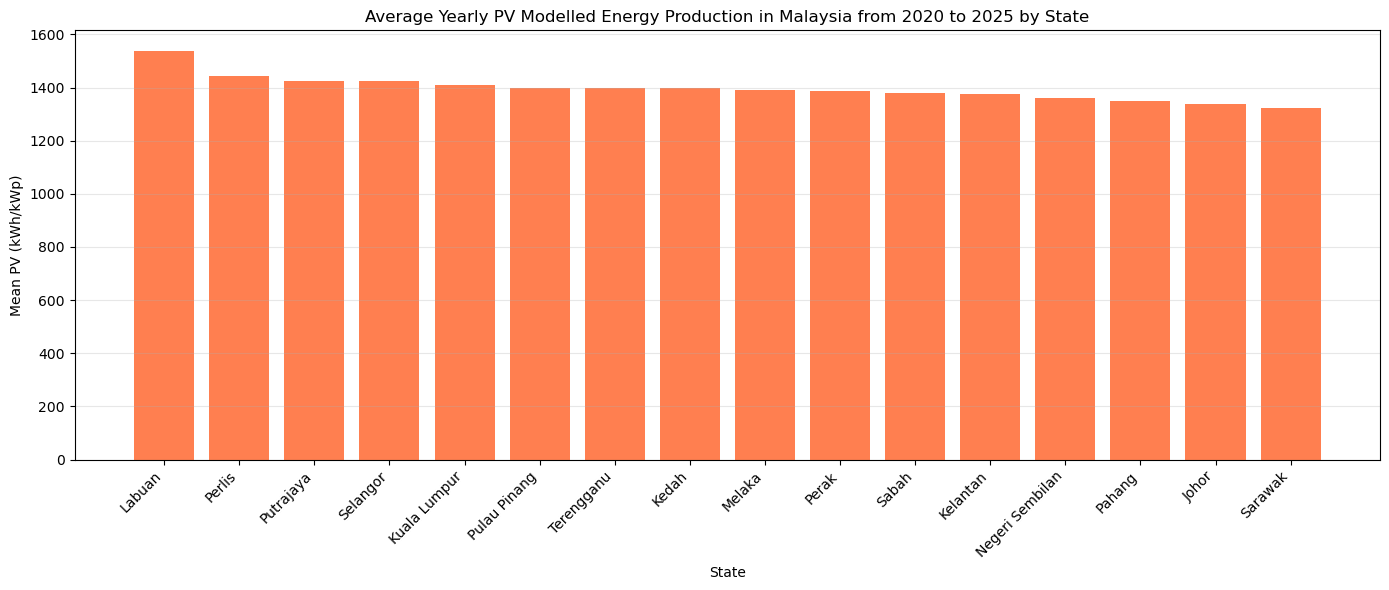

In [ ]:
da = pv_by_state  

state_ids = da["state_id"].values.astype(int)
pv_values = da.values

state_names = [state_lookup.get(int(i), f"Unknown-{int(i)}") for i in state_ids]

# Sort by pv_values (descending)
order = np.argsort(pv_values)[::-1]
state_names_sorted = [state_names[i] for i in order]
pv_values_sorted = pv_values[order]

plt.figure(figsize=(14, 6))
plt.bar(state_names_sorted, pv_values_sorted, color = 'coral')

plt.xlabel("State")
plt.ylabel("Mean PV (kWh/kWp)")
plt.title("Average Yearly PV Modelled Energy Production in Malaysia from 2020 to 2025 by State")

plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()